# Chapter 4 - Evaluation and Optimization

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


We generate two inputs:
* features – a matrix of input features
* target – an array of target variables corresponding to those features

In [72]:
features = rand(100,5)
target = rand(100) > 0.5

### The holdout method

We divide into a randomized training and test set:

In [73]:
N = features.shape[0]
N_train = floor(0.7 * N)

# Randomize index
# Note: sometimes you want to retain the order in the dataset and skip this step
# E.g. in the case of time-based datasets where you want to test on 'later' instances
idx = random.permutation(N)

# Split index
idx_train = idx[:N_train]
idx_test = idx[N_train:]

# Break your data into training and testing subsets
features_train = features[idx_train,:]
target_train = target[idx_train]
features_test = features[idx_test,:]
target_test = target[idx_test]

# Build, predict, evaluate (to be filled out)
# model = train(features_train, target_train)
# preds_test = predict(model, features_test)
# accuracy = evaluate_acc(preds_test, target_test)

In [74]:
print features_train.shape
print features_test.shape
print target_train.shape
print target_test.shape

(70, 5)
(30, 5)
(70,)
(30,)


### K-fold cross-validation

In [75]:
N = features.shape[0]
K = 10 # number of folds

preds_kfold = np.empty(N)
folds = np.random.randint(0, K, size=N)

for idx in np.arange(K):

    # For each fold, break your data into training and testing subsets
    features_train = features[folds != idx,:]
    target_train = target[folds != idx]
    features_test = features[folds == idx,:]
    
    # Print the indices in each fold, for inspection
    print nonzero(folds == idx)[0]

    # Build and predict for CV fold (to be filled out)
    # model = train(features_train, target_train)
    # preds_kfold[folds == idx] = predict(model, features_test)
    
# accuracy = evaluate_acc(preds_kfold, target)

[16 20 42 48 54 57 77 86]
[ 0 10 11 12 19 31 35 37 41 44 46 61 64 70 71 76 89 97 98]
[ 3  5  7 34 40 45 66 68 74 90]
[ 2 22 24 38 39 43 62 63 67 72 81 82]
[ 4 15 28 29 36 47 92]
[58 65 69 88]
[17 23 50 59 87 95 96]
[ 1  6 14 30 49 56 73 94]
[ 9 13 25 26 32 33 52 53 55 60 75 78 79 80 83 91 93 99]
[ 8 18 21 27 51 84 85]


### The ROC curve

In [83]:
def roc_curve(true_labels, predicted_probs, n_points=100, pos_class=1):
    thr = linspace(0,1,n_points)
    tpr = zeros(n_points)
    fpr = zeros(n_points)

    pos = true_labels == pos_class
    neg = logical_not(pos)
    n_pos = count_nonzero(pos)
    n_neg = count_nonzero(neg)
      
    for i,t in enumerate(thr):
        tpr[i] = count_nonzero(logical_and(predicted_probs >= t, pos)) / n_pos
        fpr[i] = count_nonzero(logical_and(predicted_probs >= t, neg)) / n_neg
    
    return fpr, tpr, thr


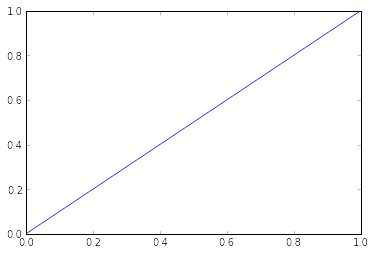

In [85]:
# Randomly generated predictions should give us a diagonal ROC curve
preds = rand(len(target))
fpr, tpr, thr = roc_curve(target, preds, pos_class=True)
plot(fpr, tpr)

### The area under the ROC curve

In [95]:
def auc(true_labels, predicted_labels, pos_class=1):
    fpr, tpr, thr = roc_curve(true_labels, predicted_labels,
 pos_class=pos_class)
    area = -trapz(tpr, x=fpr)
    return area

In [96]:
auc(target, preds, pos_class=True)

0.5

### The root-mean-square error

In [98]:
def rmse(true_values, predicted_values):
    n = len(true_values)
    residuals = 0
    for i in range(n):
        residuals += (true_values[i] - predicted_values[i])**2.
    return np.sqrt(residuals/n)

In [99]:
rmse(rand(10), rand(10))

0.37089829945640895

### The R-squared error

In [101]:
def r2(true_values, predicted_values):
    n = len(true_values)
    mean = np.mean(true_values)
    residuals = 0
    total = 0
    for i in range(n):
        residuals += (true_values[i] - predicted_values[i])**2.
        total += (true_values[i] - mean)**2.
    return 1.0 - residuals/total

In [116]:
r2(arange(10)+rand(), arange(10)+rand(10))

0.98210713081002676

### Grid search with kernel-SVM model

Importing modules:

In [117]:
import pandas
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

Loading data and performang poor-mans feature engineering:

In [122]:
d = pandas.read_csv("data/titanic.csv")

# Target
y = d["Survived"]

# Features
X = d.drop(["Survived", "PassengerId", "Cabin","Ticket","Name", "Fare"], axis=1)
X['Sex'] = map(lambda x: 1 if x=="male" else 0, X['Sex'])
X['Embarked-Q'] = map(lambda x: 1 if x=="Q" else 0, X['Embarked'])
X['Embarked-C'] = map(lambda x: 1 if x=="C" else 0, X['Embarked'])
X['Embarked-S'] = map(lambda x: 1 if x=="S" else 0, X['Embarked'])
X = X.drop(["Embarked", "Sex"], axis=1)
X = X.fillna(-1)

Performing grid-search to find the optimal hyper-parameters:

In [123]:
# grid of (gamma, C) values to try 
gam_vec, cost_vec = np.meshgrid(np.linspace(0.01, 10, 11),
                     np.linspace(0.01, 10, 11))

AUC_all = [] # initialize empty array to store AUC results

# set up cross-validation folds
N = len(y)
K = 10 # number of cross-validation folds
folds = np.random.randint(0, K, size=N)

# search over every value of the grid
for param_ind in np.arange(len(gam_vec.ravel())):

    # initialize cross-validation predictions
    y_cv_pred = np.empty(N)

    # loop through the cross-validation folds
    for ii in np.arange(K):
        # break your data into training and testing subsets
        X_train = X.ix[folds != ii,:]
        y_train = y.ix[folds != ii]
        X_test = X.ix[folds == ii,:]

        # build a model on the training set
        model = SVC(gamma=gam_vec.ravel()[param_ind], C=cost_vec.ravel()[param_ind])
        model.fit(X_train, y_train)

        # generate and store model predictions on the testing set
        y_cv_pred[folds == ii] = model.predict(X_test)

    # evaluate the AUC of the predictions
    AUC_all.append(roc_auc_score(y, y_cv_pred))

indmax = np.argmax(AUC_all)
print "Maximum = %.3f" % (np.max(AUC_all))
print "Tuning Parameters: (gamma = %.2f, C = %.2f)" % (gam_vec.ravel()[indmax], cost_vec.ravel()[indmax])

Maximum = 0.671
Tuning Parameters: (gamma = 0.01, C = 7.00)
